In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper.ps as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

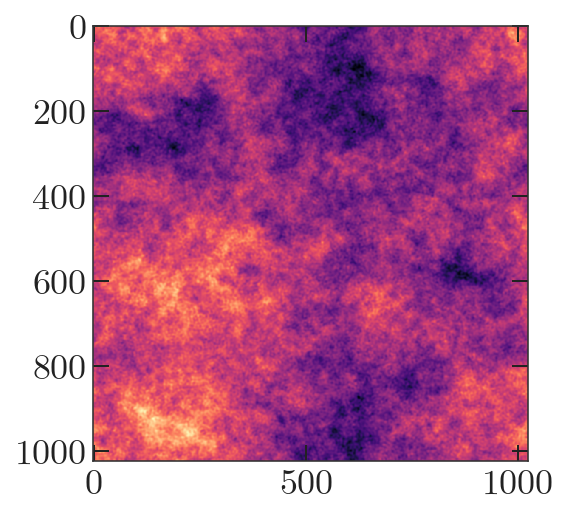

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

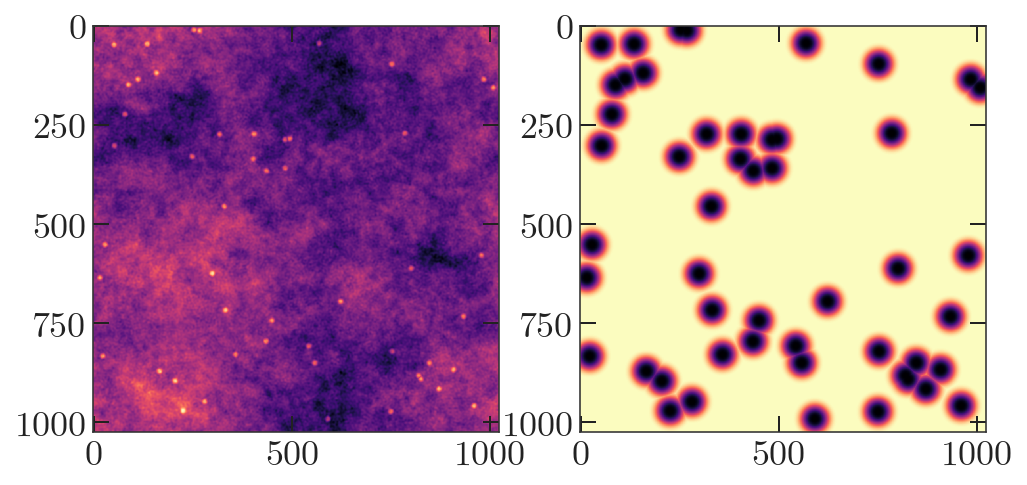

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-nw.apod_C2(mask, 0.1)
imap += point_source_map
mask = nw.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

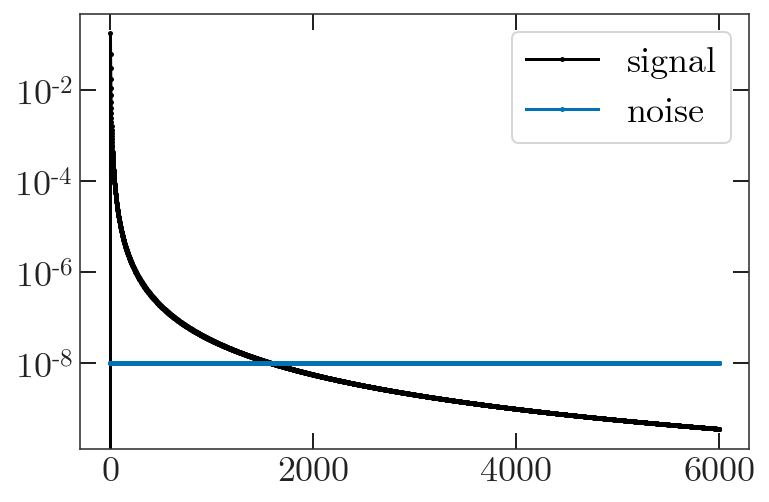

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="signal")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([ 1.09414062e-04, -1.04462427e-06,  6.32628151e-06,  2.12180743e-06,
        1.13271277e-06,  1.49049363e-06,  6.59156150e-07,  2.96745418e-07,
        4.58978687e-07,  2.88554490e-07,  1.22541921e-07,  1.15192499e-07,
        1.28275206e-07,  5.59309903e-08,  9.92783516e-08,  4.87369400e-08,
        4.84313722e-08,  3.62652390e-08,  3.87571807e-08,  2.89809691e-08,
        3.18308071e-08,  2.23591344e-08,  1.51366191e-08,  2.12668385e-08,
        1.59698437e-08,  2.19133753e-08,  1.30384771e-08,  1.50756048e-08,
        1.27791771e-08,  1.71059877e-08,  8.23940494e-09,  1.09852269e-08,
        1.02860430e-08,  1.03036636e-08,  8.34285091e-09,  8.27630560e-09,
        5.59990622e-09,  6.95679190e-09,  6.72700075e-09,  5.88585956e-09,
        3.85861578e-09,  4.60289064e-09,  3.50640707e-09,  4.78565955e-09,
        3.40520080e-09,  2.67936056e-09,  1.91783489e-09,  2.15200715e-09,
        1.97057442e-09,  1.03657474e-09,  7.94453647e-10,  8.01667773e-10,
        3.25718044

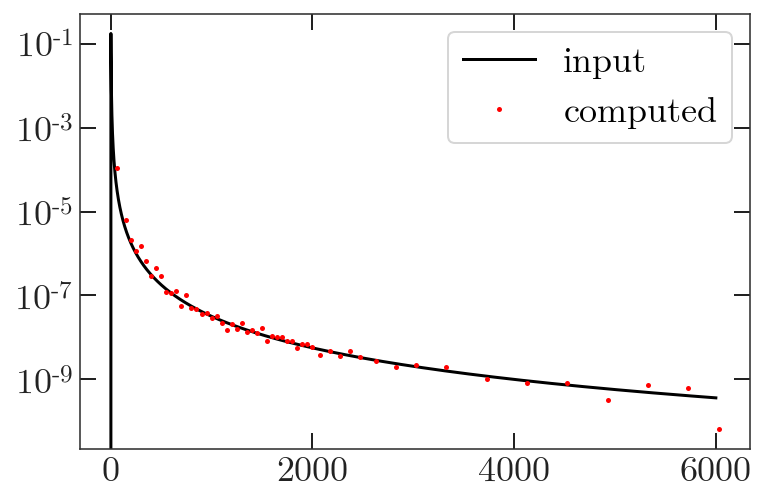

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')